# Apache Sedona with PostGIS 
Apache Sedona (previously GeoSpark) is a geospatial engine for distributed computing that integrates with Apache Spark. It allow to process large geospatial datasets across clusters, integrates Spark SQL layer, provides similar queries like PostGIS, implements spatial operations and geometry based on the Java Topology Suite (JTS), provides spatial indexing (quadtree, R-tree) and batch and streaming spatial analytics.

This notebook demonstrates how to use Apache Sedona linked with PostGIS for spatial data processing and analysis. 

**Documentation:**
- [Apache Sedona Documentation](https://sedona.apache.org/latest/tutorial/sql/)
- [How to create Geometries in Sedona](https://sedona.apache.org/latest-snapshot/api/sql/Constructor/) including all sorts of functions like `ST_GeomFromWKT`, `ST_GeomFromGeoJSON`, `ST_Point`, etc.
- [Sedona Python Documentation](https://sedona.apache.org/latest/api/pydocs/index.html)

**Prerequisites**
1. Start the docker container with Apache Sedona and PostGIS installed. Either using Docker Desktop or using the command line.
2. Once the container is running you can access the Jupyter using your web browser at `http://localhost:8888`. In case you want to use the Jupyter notebook from VS Code, open the project folder in VS Code (you may need to install the Jupyter extension). Then try to run the first code cell and you'll be prompted to select a kernel, select *Jupyter Server* connect and connect to the Jupyter server at `http://localhost:8888` and the Python 3 kernel.
3. In case you have a PostgreSQL database locally running on your machine, stop the service on your machine to avoid port conflicts with the PostGIS database running in the Docker container.

**Contents**
This notebook covers the following topics step by step:

- Initialise Sedona and Spark, and check if the connection to PostGIS is working
- Load spatial data from PostGIS and convert it to Sedona DataFrame
- Perform spatial queries using Sedona SQL functions
- Load geospatial data from Parquet files and convert to geometries
- Load geodatasets from STAC API
- Load geoparquet files
- Load csv files and convert to geometries 
- Visualize geospatial data using Kepler.gl and Folium


**Files**
- `ist-daten-sbb.parquet` via [https://data.sbb.ch](https://data.sbb.ch/explore/dataset/ist-daten-sbb/export/?flg=de)
- `linie-mit-polygon.parquet` via [https://data.sbb.ch](https://data.sbb.ch/explore/dataset/linie-mit-polygon/export/)
- `stop-points-today.parquet` via [https://data.oev-info.ch](https://data.oev-info.ch/explore/dataset/stop-points-today)
- `Betriebspunkte.csv` via [https://data.geo.admin.ch](https://data.geo.admin.ch/browser/index.html#/collections/ch.bav.haltestellen-oev/)
- `test5.diff` vis [Apache Sedona Usecases](https://github.com/apache/sedona/tree/master/docs/usecases)

In [1]:
# First run of this cell takes a bit of time to set up the Spark session
from pyspark.sql import SparkSession
from sedona.spark import SedonaContext
# Initialize Spark and Sedona 
# (your may need to wait a bit for the docker containers to properly start)
spark = (SparkSession.builder.appName("Sedona + PostGIS").getOrCreate())
sedona = SedonaContext.create(spark) # initiatie Sedona context

print("Spark:", spark.version)
print("Spark jars:", spark.sparkContext.getConf().get("spark.jars"))

25/12/02 14:18:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark: 4.0.1
Spark jars: file:///opt/jars/postgresql-42.7.4.jar


25/12/02 14:18:36 WARN UDTRegistration: Cannot register UDT for org.geotools.coverage.grid.GridCoverage2D, which is already registered.
25/12/02 14:18:36 WARN SimpleFunctionRegistry: The function rs_union_aggr replaced a previously registered function.
25/12/02 14:18:36 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.geom.Geometry, which is already registered.
25/12/02 14:18:36 WARN UDTRegistration: Cannot register UDT for org.apache.sedona.common.S2Geography.Geography, which is already registered.
25/12/02 14:18:36 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.index.SpatialIndex, which is already registered.
25/12/02 14:18:36 WARN SimpleFunctionRegistry: The function st_envelope_aggr replaced a previously registered function.
25/12/02 14:18:36 WARN SimpleFunctionRegistry: The function st_envelope_aggr replaced a previously registered function.
25/12/02 14:18:36 WARN SimpleFunctionRegistry: The function st_intersection_aggr replaced a previously 

In [2]:
# Set up JDBC (Java Database Connection) connection parameters to the PostGIS database "gis"
# Verify that there is not another postgres instance running on the host machine on port 5432
jdbc_url = "jdbc:postgresql://host.docker.internal:5432/gis" 
# (if your too lazy to stop your local postgres instance, 
# use dockername with postgis for internal docker networking)
# jdbc_url = "jdbc:postgresql://sedona-postgis:5432/gis" 
db_properties = {"user": "postgres", 
                 "password": "postgres", 
                 "driver": "org.postgresql.Driver"}
# Test basic JDBC connection
try:
    test_df = (spark.read.format("jdbc").option("url", jdbc_url)
               .option("dbtable", "(SELECT version())")
               .options(**db_properties).load())    
    print("✅ Connection successful!")
    test_df.show(truncate=False)
except Exception as e:
    print("❌ Connection failed:")
    print(str(e))

✅ Connection successful!
+---------------------------------------------------------------------------------------------------------------------------+
|version                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------+
|PostgreSQL 16.4 (Debian 16.4-1.pgdg110+2) on x86_64-pc-linux-gnu, compiled by gcc (Debian 10.2.1-6) 10.2.1 20210110, 64-bit|
+---------------------------------------------------------------------------------------------------------------------------+



## Import spatial data from PostGIS
With the *query* option you can read and convert to spatial data from JDBC data sources (e.g., PostGIS). In case of PostGIS there's no need to convert the geometries, as it's already using EWKB format (see: [Load data from JDBC data sources](https://sedona.apache.org/latest/tutorial/sql/#load-data-from-jdbc-data-sources))

The following code cell show three examples how to read spatial data from PostGIS.
- Example 1: Sedona read and convert geometries
- Example 2: Sedona read directly as spatial data from PostGIS
- Example 3: For reference with standard Spark JDBC read (non-spatial) from PostGIS and convert.

ps. the () brackets around the sedona call, are only needed to split the code into multiple lines for better readability.


In [26]:
# Example 1: Sedona read directly as spatial data from PostGIS
from pyspark.sql import functions as f
df = (sedona.read.format("jdbc")
      .option("url", jdbc_url).options(**db_properties)    # connection parameters
      .option("dbtable", "public.cb_2018_us_state_500k").load()    # table to read
      .withColumn("geom", f.expr("ST_GeomFromWKB(geom)"))) # convert to geometry
# df.printSchema()
# df.count()
df.show(5,truncate=False)

+---+-------+--------+-----------+-----+------+--------------+----+----------------+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
# Example 2: Sedona read and convert geometries
sql_query = "(SELECT gid, name, ST_AsBinary(geom) AS geom FROM public.cb_2018_us_state_500k)"
df = (sedona.read.format("jdbc")
      .option("url", jdbc_url).options(**db_properties)    # JDBC connection options
      .option("query", sql_query).load()                   # SQL query to read data and load data
      .withColumn("geom", f.expr("ST_GeomFromWKB(geom)"))) # convert WKB to geometry
# df.printSchema()
# df.count()
df.show(5,truncate=False)

+---+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [35]:
# Example 3: For reference with standard Spark JDBC read (non-spatial) from PostGIS and convert.
# SQL query with the conversion of geometries to WKT with ST_AsText() as Spark 
# cannot natively read PostGIS geometry types
from pyspark.sql.functions import expr
sql_query = "(SELECT gid, name, ST_AsText(geom) AS geom FROM public.cb_2018_us_state_500k)"
df = (spark.read.format("jdbc")
             .option("url", jdbc_url).options(**db_properties) # SQL query to read data and load data
             .option("dbtable",sql_query).load())
# Convert WKT geometries to Sedona geometry types
sedona_df = df.select("gid", "name", expr("ST_GeomFromWKT(geom)").alias("geometry"))
sedona_df.show(3,truncate=False)

+---+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Sample spatial query
The two following code cells show how to perform a spatial query using Sedona SQL functions with the data.frames loaded from PostGIS and converted to Sedona geometry types.

Query: Find points within polygons.

The first code cell uses Sedona SQL functions, the second code cell uses Spark SQL functions.

In [6]:
%%time
# Sedona:
from pyspark.sql import functions as f
# Read Sedona geometries from PostGIS tables and perform spatial query
polygons_df = (sedona.read.format("jdbc")
      .option("url", jdbc_url).options(**db_properties)    # connection parameters
      .option("dbtable", "public.demo_polygons").load()    # table to read
      .withColumn("geom", f.expr("ST_GeomFromWKB(geom)"))  # convert to geometry
      .withColumnRenamed("geom", "geometry"))              # rename column
points_df = (sedona.read.format("jdbc")
      .option("url", jdbc_url).options(**db_properties)    # connection parameters
      .option("dbtable", "public.demo_points").load()      # table to read
      .withColumn("geom", f.expr("ST_GeomFromWKB(geom)"))  # convert to geometry
      .withColumnRenamed("geom", "geometry"))              # rename column
# points_df.printSchema()
# polygons_df.printSchema()
# Create temporary views for SQL queries
polygons_df.createOrReplaceTempView("polygons")
points_df.createOrReplaceTempView("points")

# Perform spatial query: Find points contained within polygons
contained_df = sedona.sql("""
    SELECT
        pnt.id        AS point_id,
        pnt.name      AS point_name,
        pnt.geometry  AS geometry,
        poly.id       AS polygon_id,
        poly.name     AS polygon_name
    FROM points pnt
    JOIN polygons poly
      ON ST_Contains(poly.geometry, pnt.geometry)
""")
# Show results
contained_df.show(truncate=False)

25/12/02 14:18:39 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


+--------+---------------------------+---------------------------+----------+-----------------------+
|point_id|point_name                 |geometry                   |polygon_id|polygon_name           |
+--------+---------------------------+---------------------------+----------+-----------------------+
|9       |Bern Bundesplatz           |POINT (7.439803 46.941539) |1         |Bern city area (demo)  |
|10      |Bern Kornhausplatz         |POINT (7.441831 46.942441) |1         |Bern city area (demo)  |
|1       |Bern, CH                   |POINT (7.4474 46.948)      |1         |Bern city area (demo)  |
|8       |Bern Hauptbahnhof          |POINT (7.440115 46.948431) |1         |Bern city area (demo)  |
|11      |Bern Restaurant Rosengarten|POINT (7.4605593 46.950862)|1         |Bern city area (demo)  |
|4       |Zürich Bellevueplatz       |POINT (8.548407 47.365347) |2         |Zurich city area (demo)|
|5       |Zürich Platzspitz          |POINT (8.539167 47.376333) |2         |Zuric

The following code cell shows how to read the with spark from PostGIS converting the geometries to WKT Strings, then convert the geometry column to Sedona geometry type using `ST_GeomFromWKB` function, and finally perform the spatial query using Sedona SQL functions.

In [7]:
%%time
# Spark:
# SQL query with the conversion of geometries to WKT with ST_AsText() as Spark 
# cannot natively read PostGIS geometry types
sql_query = "(SELECT id, name, ST_AsText(geom) AS geom FROM public.demo_points)"
points_sdf = (spark.read.format("jdbc")
             .option("url", jdbc_url).options(**db_properties) # SQL query to read data and load data
             .option("dbtable",sql_query).load())
sql_query = "(SELECT id, name, ST_AsText(geom) AS geom FROM public.demo_polygons)"
polygons_sdf = (spark.read.format("jdbc")
             .option("url", jdbc_url).options(**db_properties) # SQL query to read data and load data
             .option("dbtable",sql_query).load())
# points_df.printSchema()
# polygons_df.printSchema()
# Register DataFrames as Sedona spatial tables
from pyspark.sql.functions import expr
# Convert WKT geometries to Sedona geometry types
sedona_polygons = polygons_sdf.select("id", "name", expr("ST_GeomFromWKT(geom)").alias("geometry"))
sedona_points = points_sdf.select("id", "name", expr("ST_GeomFromWKT(geom)").alias("geometry"))
# sedona_polygons.printSchema()
# sedona_points.printSchema()
# Create temporary views for SQL queries
sedona_polygons.createOrReplaceTempView("polygons")
sedona_points.createOrReplaceTempView("points")
# Perform spatial query: Find points contained within polygons
contained_df = sedona.sql("""
    SELECT
        pnt.id        AS point_id,
        pnt.name      AS point_name,
        pnt.geometry  AS geometry,
        poly.id       AS polygon_id,
        poly.name     AS polygon_name
    FROM points pnt
    JOIN polygons poly
      ON ST_Contains(poly.geometry, pnt.geometry)
""")
# Show results
contained_df.show(truncate=False)

+--------+---------------------------+---------------------------+----------+-----------------------+
|point_id|point_name                 |geometry                   |polygon_id|polygon_name           |
+--------+---------------------------+---------------------------+----------+-----------------------+
|9       |Bern Bundesplatz           |POINT (7.439803 46.941539) |1         |Bern city area (demo)  |
|10      |Bern Kornhausplatz         |POINT (7.441831 46.942441) |1         |Bern city area (demo)  |
|1       |Bern, CH                   |POINT (7.4474 46.948)      |1         |Bern city area (demo)  |
|8       |Bern Hauptbahnhof          |POINT (7.440115 46.948431) |1         |Bern city area (demo)  |
|11      |Bern Restaurant Rosengarten|POINT (7.4605593 46.950862)|1         |Bern city area (demo)  |
|4       |Zürich Bellevueplatz       |POINT (8.548407 47.365347) |2         |Zurich city area (demo)|
|5       |Zürich Platzspitz          |POINT (8.539167 47.376333) |2         |Zuric

25/12/02 14:18:39 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


## Save analysis results back to PostGIS
You may want to save analysis results back to PostGIS, to easily visualize them in a GIS software like QGIS or serve these on a web map using e.g. GeoServer.

To save spatial data back to PostGIS using Sedona, the geometry column needs to be converted to EWKB format (Extended Well-Known Binary) using the `ST_AsEWKB` function. The following code cell shows how to do this (see [Save to PostGIS](https://sedona.apache.org/latest/tutorial/sql/?h=sedona.sql#save-to-postgis)).

In [8]:
# save results back to PostGIS
# https://sedona.apache.org/latest/tutorial/sql/?h=sedona.sql#save-to-postgis
(contained_df.withColumn("geometry", expr("ST_AsEWKB(geometry)"))
                        .write.format("jdbc")
                        .option("url", jdbc_url).options(**db_properties)
                        .option("dbtable", "public.points_within_polygons") 
                        .option("truncate","true").mode("overwrite").save())
# Check if results have been saved correctly to PostGIS
check_df = (sedona.read.format("jdbc")
            .option("url", jdbc_url).options(**db_properties)    # connection parameters
            .option("dbtable", "public.points_within_polygons").load()    # table to read
            .withColumn("geom", f.expr("ST_GeomFromWKB(geometry)"))) # convert to geometry
# df.printSchema()
# df.count()
check_df.show(5,truncate=False)

25/12/02 14:18:40 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


+--------+---------------------------+----------------------------------------------------------------+----------+---------------------+---------------------------+
|point_id|point_name                 |geometry                                                        |polygon_id|polygon_name         |geom                       |
+--------+---------------------------+----------------------------------------------------------------+----------+---------------------+---------------------------+
|9       |Bern Bundesplatz           |[01 01 00 00 00 13 BB B6 B7 5B C2 1D 40 4B 74 96 59 84 78 47 40]|1         |Bern city area (demo)|POINT (7.439803 46.941539) |
|10      |Bern Kornhausplatz         |[01 01 00 00 00 97 6F 7D 58 6F C4 1D 40 6C B4 1C E8 A1 78 47 40]|1         |Bern city area (demo)|POINT (7.441831 46.942441) |
|1       |Bern, CH                   |[01 01 00 00 00 EE EB C0 39 23 CA 1D 40 D3 4D 62 10 58 79 47 40]|1         |Bern city area (demo)|POINT (7.4474 46.948)      |
|8       |

## Visualisation 
Following sections show different options to visualize geospatial data in the notebook using Matplotlib, Kepler.gl and Folium.


### Visualisation with Matplotlib
Matplotlib is useful to quickly visualise static maps in 2D. The docker image with Sedona includes Matplotlib by default.

In [9]:
# Convert Sedona DataFrames to GeoPandas GeoDataFrames
import geopandas as gpd
polygons_pandas = polygons_df.toPandas()
polygons_gdf = gpd.GeoDataFrame(polygons_pandas, geometry='geometry', crs='EPSG:4326')
points_pandas = points_df.toPandas()
points_gdf = gpd.GeoDataFrame(points_pandas, geometry='geometry', crs='EPSG:4326')
contained_pandas = contained_df.toPandas()
contained_gdf = gpd.GeoDataFrame(contained_pandas, geometry='geometry', crs='EPSG:4326')

25/12/02 14:18:41 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


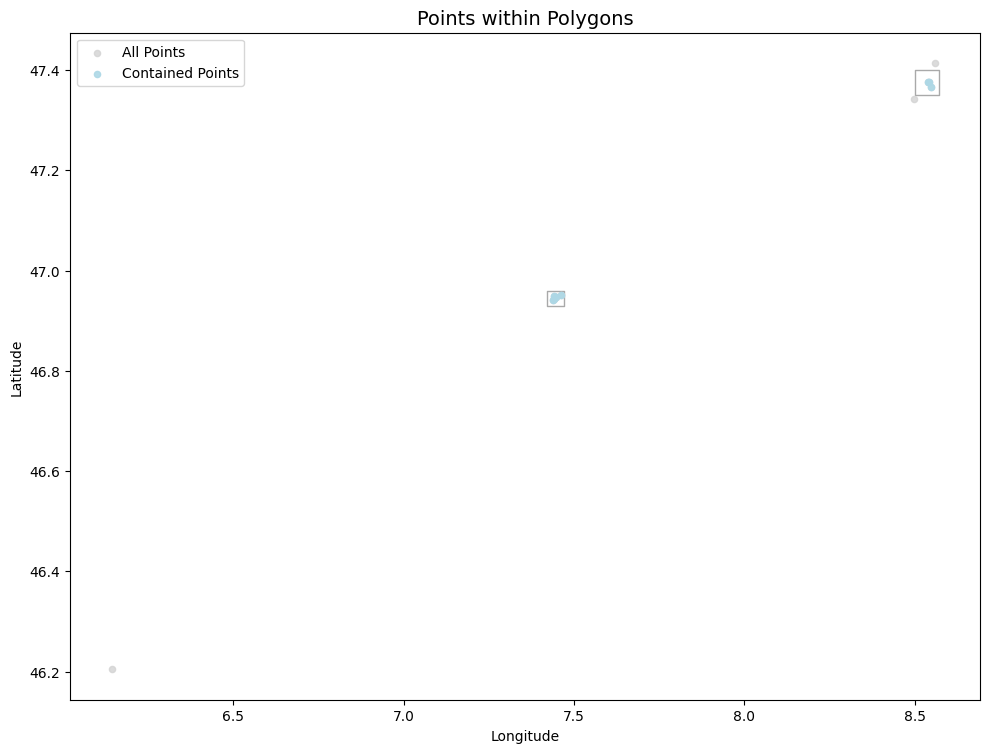

In [10]:
import matplotlib.pyplot as plt
# Visualise results with Matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
polygons_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgrey', linewidth=1, alpha=1)
points_gdf.plot(ax=ax, color='lightgrey', markersize=20, alpha=0.8, label='All Points')
contained_gdf.plot(ax=ax, color='lightblue', markersize=20, alpha=0.9, label='Contained Points')
plt.title('Points within Polygons', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Visualisation with Kepler.gl
In case the Kepler.gl extension doesn't load, you may need to change settings in vs code to allow loading of widgets from external sources. Open user settings (Ctrl + ,), go to *Users / Extensions / Jupyter* scroll way down to *Widget Script Sources* and open the url pointing to `settings.json`. Include the following entry to the list of allowed sources:
```json
{
    ...
    "python.useEnvironmentsExtension": true,
    "jupyter.widgetScriptSources": [
        "jsdelivr.com",
        "unpkg.com"
    ]
}
```
Restart the Kernel and if that doesn't help use the *reload Window* command from the command palette (Ctrl + Shift + P) and run the cell again (with the required previous cells executed). Or Open the notebook in the browser directly using `http://localhost:8888` and then apply *reload window* command.

For the Documentation see [SedonaKepler](https://sedona.apache.org/latest/api/sql/Visualization-SedonaKepler)

In [11]:
# !jupyter labextension list
# Load Kepler.gl map with SedonaKepler and add dataframes to display
from sedona.spark import SedonaKepler
map = SedonaKepler.create_map(contained_df, "contained")
SedonaKepler.add_df(map, points_df, "points")
SedonaKepler.add_df(map,polygons_df, "polygons" )
map

25/12/02 14:18:42 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


KeplerGl(data={'contained': {'index': [0, 1, 2, 3, 4, 5, 6, 7], 'columns': ['point_id', 'point_name', 'geometr…

### Visualisation with Folium
Folium is a python library to create interactive maps with Leaflet.js and geopandas. The docker image with Sedona does not include Folium by default, so you need to install it first using `!pip install folium` command in a code cell and restart the kernel.

Hence, to visualise sedona spatial data.frame in folium, we need to convert these to geopandas with the Geopanda API for Apache Sedona (see [Sedona GeoPandas API](https://sedona.apache.org/latest/tutorial/geopandas-api/?h=geopanda))

In [12]:
# Folium is not installed by default in the Sedona docker image, and needs
# to be installed with every restart of the docker image.
# run the following command to install it:
!pip install folium
# restart the python kernel after installation!

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [13]:
# Sometimes folium doesn't work properly (grey map only) in JupyterLab,
# in this case, restart the jupyter notebook.
import folium
# Create folium map
map = folium.Map(location=[47, 8], tiles="CartoDB Positron", zoom_start=9)
folium.GeoJson(polygons_gdf).add_to(map)
folium.GeoJson(points_gdf,
               marker=folium.CircleMarker(radius=5, fill=True, fillColor='lightblue', 
                                          color='blue', fillOpacity=0.7)).add_to(map)
folium.GeoJson(contained_gdf,
               marker=folium.CircleMarker(radius=5, fill=True, fillColor='lightgreen', 
                                          color='green', fillOpacity=0.7)).add_to(map)
folium.LayerControl().add_to(map)
map

ModuleNotFoundError: No module named 'folium'

## Reading different (spatial) file formats
Both Spark and Sedona provide reader for various file formats with slightly different notations ([Sedona Documentation](https://sedona.apache.org/latest/) under *Programming Guides / Files*, [Spark Data Sources](https://spark.apache.org/docs/latest/sql-data-sources.html)).  


### Read Parquet files
Reading files with the spark reader `spark.read.parquet(...)` results in a standard Spark DataFrame, while reading files with the sedona reader `sedona.read.format("<formatname>").load(...)` results in a Sedona DataFrame.
Reading spatial data from Parquet files and converting to geometries

In [ ]:
# Reading Parquet Files with Spark and Sedona
# Read the Parquet file using Spark's read API
# rawdf = spark.read.parquet("/opt/workspace/data/stop-points-today.parquet")
# Read the Parquet with Sedona's read API
rawdf = sedona.read.format("parquet").load("/opt/workspace/data/stop-points-today.parquet")
# Display basic information
# df.printSchema()
rawdf.show(5)
rawdf.count()

The loaded Parquet file contains coordinate columns, here named *lv95east, lv95north*. Convert these columns to geometries using the Sedona function `ST_Point(lv95east, lv95north)`. If a column contains WKT geometries, you can use the function `ST_GeomFromWKT(<wkt_column>)` to convert it to geometries. Set the correct SRID using the function `ST_SetSRID(<geometry>, <srid>)` and wrap the geometry with the ST_SetSRID function.

In [ ]:
# convert two columns lv95east and lv95north to a geometry column
spatialdf = rawdf.withColumn("geometry", expr("ST_SetSRID(ST_Point(lv95east, lv95north), 2056)"))
# show the new dataframe with the geometry column
spatialdf.select("sloid", "designationofficial", "geometry").show(5)

### Read CSV files
Read CSV-files and convert columns with coordinates to geometries the same way as in the example above.

In [ ]:
# Load a csv file with coordinates and convert to geometry
# Betriebspunkt.csv 
# https://data.geo.admin.ch/browser/index.html#/collections/ch.bav.haltestellen-oev/
csvdf = spark.read.option("header", "true").csv("/opt/workspace/data/Betriebspunkt.csv")
# csvdf.show(5) # Show all columns
# convert two columns E, N to a geometry column
spatialcsv = csvdf.withColumn("geometry", expr("ST_Point(E, N)"))
spatialcsv.select("Name", "Abkuerzung", "geometry").show(5)

### Read GeoParquet files
Sedona provides a reader for GeoParquet files. Use the sedona reader `sedona.read.format("geoparquet").load(<filepath>)` to read GeoParquet files directly as Sedona DataFrame with spatial capabilities.

In [ ]:
from pyspark.sql import functions as f
df = sedona.read.format("geoparquet").load("/opt/workspace/data/ist-daten-sbb.parquet")
line_df = sedona.read.format("geoparquet").load("/opt/workspace/data/linie-mit-polygon.parquet")
summary_df = (df.groupBy("bpuic").agg(
    f.sum(f.when(f.col("ankunftsverspatung") == True, 1).otherwise(0)).alias("count_ankunftsverspatung"),
    f.sum(f.when(f.col("abfahrtsverspatung") == True, 1).otherwise(0)).alias("count_abfahrtverspatung"),
    f.first("geopos").alias("geometry")
))
# summary_df.printSchema()
summary_df.show(5)

In [ ]:
# Convert to geopandas for visualisation
df_pandas = summary_df.toPandas()
gdf = gpd.GeoDataFrame(df_pandas, geometry='geometry', crs='EPSG:4326')
line_df_pandas = line_df.toPandas()
line_gdf = gpd.GeoDataFrame(line_df_pandas, geometry='geo_shape', crs='EPSG:4326')
# Visualisation with Matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
line_gdf.plot(ax=ax, facecolor='none', edgecolor='lightgrey', linewidth=1, alpha=1)
gdf.plot(ax=ax, column='count_ankunftsverspatung', cmap='OrRd', markersize=20, 
         alpha=0.9, label='Number of Arrival Delays')
# gdf.plot(figsize=(10, 8), edgecolor='blue', linewidth=2, alpha=0.6)
plt.title('Delays', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Read GeoTIFF files
Sedona provides a reader for GeoTIFF files. Use the sedona reader `sedona.read.format("geotiff").load(<filepath>)` to read GeoTIFF files. For more details on Raster DataFrames on Sedona see [Raster DataFrame / SQL app](https://sedona.apache.org/latest/tutorial/raster/) and the notebook [ApacheSedonaRaster.ipynb](https://github.com/apache/sedona/blob/master/docs/usecases/ApacheSedonaRaster.ipynb) on GitHub.

In [ ]:
# Load the Cloud Optimized GeoTIFF from URL
# geotiff_df = sedona.read.format("binaryFile").load("data/swiss-map-raster1000_1000_kgrel_50_2056.tif")
geotiff_df = sedona.read.format("binaryFile").load("data/test5.tiff")
geotiff_df.show(2)
geotiff_df.printSchema()
# Create a temporary view for SQL queries
geotiff_df.createOrReplaceTempView("binary_raster")
# # Show basic information
geotiff_df.printSchema() 

In [ ]:
# Sedona SQL to read the GeoTIFF content as raster
raster_df = sedona.sql("SELECT RS_FromGeoTiff(content) as raster from binary_raster")
raster_df.show(2)
raster_df.createOrReplaceTempView("raster_table")
# Get raster metadata
raster_metadata = sedona.sql("SELECT RS_MetaData(raster) as metadata from raster_table")
metadata = raster_metadata.first()[0]
raster_srid = metadata[8]
metadata

In [ ]:
from sedona.spark import *
# from IPython.display import display, HTML
SedonaUtils.display_image(raster_df.selectExpr("RS_AsImage(raster, 500)"))